In [1]:
import utils
from get_dataset import get_dataset
import random
import time
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torchtext.data import Iterator
from importlib import reload

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset, emb_weights = get_dataset()

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

<br>

In [3]:
class Baseline_model(nn.Module):
  """
  """
  def __init__(self, vocab_size, embed_dim, embed_vecs=None):
    super().__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
    if embed_vecs is not None:
      self.embedding = nn.EmbeddingBag.from_pretrained(embed_vecs)
    else:
      self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
    self.fc1 = nn.Linear(embed_dim, embed_dim//2)
    self.fc2 = nn.Linear(embed_dim//2, 2)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.embedding(x)
    out = self.relu(self.fc1(out))
    return self.fc2(out)

In [4]:
def learner(model, loss_fn, optimiser, epochs=1, device=device):
  start_time = time.time()
  for epoch in range(epochs):
    
    total_loss = 0
    for i, batch in enumerate(Iterator(ds_train, 1, shuffle=True, device=device), 1):
      optimiser.zero_grad()

      output = model(batch.review)
      loss = loss_fn(output, batch.label)
      total_loss += loss.item()

      loss.backward()
      optimiser.step()

      if not i % (len(ds_train)//3):
        avg_loss = total_loss / (len(ds_train)//3)
        val_loss, val_accuracy = utils.validate(ds_val, loss_fn, model)
        print('Epoch : {}, batch : {}, train_loss = {:.4f}, val_loss = {:.4f}, val_accuracy : {:.3f}, time = {:.0f}s'.format(
            epoch + 1, i, avg_loss, val_loss, val_accuracy, time.time() - start_time))
        total_loss = 0

<br>

In [5]:
vocab_size = len(emb_weights)
embed_size = 300

model = Baseline_model(vocab_size, embed_size, emb_weights).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = Adam(model.parameters())

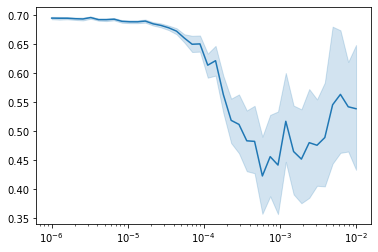

In [6]:
utils.lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-6, 1e-2])

In [7]:
optimiser = Adam(model.parameters(), lr=2e-4)
learner(model, loss_fn, optimiser, epochs=5)

Epoch : 1, batch : 800, train_loss = 0.6484, val_loss = 0.5900, val_accuracy : 0.717, time = 2s
Epoch : 1, batch : 1600, train_loss = 0.5095, val_loss = 0.4901, val_accuracy : 0.790, time = 3s
Epoch : 1, batch : 2400, train_loss = 0.4700, val_loss = 0.4587, val_accuracy : 0.767, time = 5s
Epoch : 2, batch : 800, train_loss = 0.4322, val_loss = 0.4443, val_accuracy : 0.773, time = 7s
Epoch : 2, batch : 1600, train_loss = 0.3844, val_loss = 0.4308, val_accuracy : 0.817, time = 8s
Epoch : 2, batch : 2400, train_loss = 0.4165, val_loss = 0.4206, val_accuracy : 0.790, time = 10s
Epoch : 3, batch : 800, train_loss = 0.3890, val_loss = 0.4272, val_accuracy : 0.803, time = 12s
Epoch : 3, batch : 1600, train_loss = 0.3531, val_loss = 0.4204, val_accuracy : 0.820, time = 14s
Epoch : 3, batch : 2400, train_loss = 0.3973, val_loss = 0.4114, val_accuracy : 0.803, time = 15s
Epoch : 4, batch : 800, train_loss = 0.3703, val_loss = 0.4229, val_accuracy : 0.803, time = 18s
Epoch : 4, batch : 1600, trai

In [8]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/model_baseline.pt')

In [9]:
model.embedding.weight.requires_grad_(True);
optimiser = Adam(model.parameters(), lr=1e-4)
learner(model, loss_fn, optimiser, epochs=5)

Epoch : 1, batch : 800, train_loss = 0.3418, val_loss = 0.4101, val_accuracy : 0.803, time = 11s
Epoch : 1, batch : 1600, train_loss = 0.2964, val_loss = 0.3918, val_accuracy : 0.833, time = 23s
Epoch : 1, batch : 2400, train_loss = 0.3421, val_loss = 0.3789, val_accuracy : 0.830, time = 35s
Epoch : 2, batch : 800, train_loss = 0.2939, val_loss = 0.3816, val_accuracy : 0.817, time = 48s
Epoch : 2, batch : 1600, train_loss = 0.2398, val_loss = 0.3720, val_accuracy : 0.837, time = 60s
Epoch : 2, batch : 2400, train_loss = 0.2891, val_loss = 0.3601, val_accuracy : 0.847, time = 72s
Epoch : 3, batch : 800, train_loss = 0.2478, val_loss = 0.3648, val_accuracy : 0.833, time = 84s
Epoch : 3, batch : 1600, train_loss = 0.1933, val_loss = 0.3604, val_accuracy : 0.860, time = 98s
Epoch : 3, batch : 2400, train_loss = 0.2420, val_loss = 0.3492, val_accuracy : 0.863, time = 113s
Epoch : 4, batch : 800, train_loss = 0.2075, val_loss = 0.3553, val_accuracy : 0.843, time = 127s
Epoch : 4, batch : 160

In [10]:
torch.save(model.state_dict(), 'models/model_baseline_fine.pt')

In [11]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*utils.validate(ds_test, loss_fn, model)))

Test loss : 0.31212, test accuracy : 0.867
